In [1]:
import sys
# nice style article  - which explicitly says I shouldn't do this
#      https://github.com/amontalenti/elements-of-python-style
# (so, at some point, but not now - sorry, I'll fix this)
sys.path.insert(0,"/Library/Python/2.7/site-packages")
#print sys.path

import time
import datetime

import math

import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
#print np.__version__
#print np.__file__

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
from matplotlib import rcParams
#print mpl.__version__
#print mpl.__file__

import json
from operator import itemgetter
%matplotlib inline

#print (sys.version)

# specific to datafile
import sqlite3


## A1: Before Building Visualization

Two questions that pop into my head before I begin ...

First, what in the world is "sqlite"?

Second, I guess I'd like to know more about the audience for this "tool" - other data scientist like myself, or the general public?


## A2: Answering the above questions

First, what in the world is "sqlite"?

OK, quick Google search suggests that sqllite is some sort of light-weight SQL database.  Lot's of references to R, so maybe it's common in that world.  It looks like there's a python module which can read this file, so I'll probably choose to do that, since that's where my familiarity is.  I also noticed that there's a node.js library too, so that might be useful to do a REAL dashboard, but that's also more work than I can likely put in over the next week.  Sorry!

Second, I guess I'd like to know more about the audience for this "tool."

If it's an internal thing, used by other data scientist, perhaps to integrate into other analyses and visualizations then I'll probably use python and make this a little more "command liney" (if that makes sense).  If the tool is targeting a more general, less technical audience (and I had more time... like a lot more time), then I'd probably go straight to node.js/javascript and do some fancier dashboard type of thing.  Unfortunately, given the time constraints, I'll stick to what I know I can do in a handful of hours ...

Anyway, onto the data ... and the visualization.

## Define Racers class
1. Constructor reads data from (hard-coded) data file/sql and puts it into a pandas dataframe
2. Data is automatically massaged to handle some small degree of funkiness
   (but options exist to simply remove the funky data, rather than fix it)
3. Some entities are extracted or transformed for future usage


In [6]:
#
# define racers class
#

class Racers:
    
    #
    # main constructor
    #
    def __init__(self, bad_data=None):
        
        # hard-code this for now ...
        self.datafile = "./racers.sqlite"
        db = sqlite3.connect(':memory:')
        db = sqlite3.connect(self.datafile)
        print "reading file: ./racers.sqlite (hard-coded)"
        
        #
        # basically, i'm copying the data from sqlite to a pandas dataframe
        # (note: you can find the table name from something like
        #        print db.execute("SELECT name FROM sqlite_master
        #                          WHERE type='table';").fetchall())
        #
        self.df = pd.read_sql_query("SELECT * FROM top_racers", db)
        
        # data massaging ..
        if bad_data is None or bad_data == "fix":
            # if we want to keep it, then we need to massage it
            self.fix_data()
        elif bad_data == "purge":
            # it's only ~1% so ditching isn't all that bad ...
            self.purge_bad_data()
                    
        # compute some useful quantities
        self.extract_info()
        self.extract_city_state()
        self.get_wave()
        self.racetime_in_sec()
        

    #
    # handling "funky" data
    #
    # * defined as rows of data with inaccurate info, or parsed strangely,
    #   or whatever.  Most of this was found as a result of some trial and
    #   error while getting familiar the data.
    #
    # * you can run the method "check_data" which encapsulates all
    #   our code used to filter/massage/clean things, and this will also
    #   give us an idea of how we did afterward ...
    #   
    def purge_bad_data(self):
 
        # 1. Row 5019 (place 5020) didn't have a final race time:
        #         id  finalPlace   hometown division   time
        # 5019  MM257    5020       "Windsor  CO"  M47 CO"
        self.df.drop(5019, inplace=True)
        #
        # inspect like this:
        # for dd in thisdb.execute("SELECT * FROM top_racers WHERE finalplace > 5015
        #                               AND finalplace < 5025;").fetchall():
        #     print dd
        
        # 2. No comma in hometown field
        self.df.drop(self.df.loc[self.df['hometown'].str.count(',') < 1].index, inplace=True)
        
        # 3. Too many commas in hometown field
        self.df.drop(self.df.loc[self.df['hometown'].str.count(',') > 1].index, inplace=True)
        
        # 4. Some time's have a weird HTML table tag in there ...
        self.df.drop(self.df.loc[self.df['time'].str.contains('td')].index, inplace=True)
        
        # 5. Strange old people ... remove them because I don't believe it ..
        self.df.drop(self.df.loc[self.df['division'] == "M99"], inplace=True)
        self.df.drop(self.df.loc[self.df['division'] == "M116"], inplace=True)

        
    def fix_data(self):
        # 1. Row 5019 (place 5020) didn't have a final race time:
        #         id  finalPlace   hometown division   time
        # 5019  MM257    5020       "Windsor  CO"  M47 CO"
        self.df.set_value(5019,'hometown', "Windsor, CO")
        self.df.set_value(5019,'division', "M47")
        self.df.set_value(5019,'time', "52:48.20")
        
        # 4. fix the weird HTML things
        self.df['time'] = self.df['time'].apply(lambda tt: tt.replace('</td','.00'))

    def extract_info(self):
        # add some fields we'll use later ..
        self.df['sex'] = self.df['division'].apply(lambda div: div[0])
        self.df['age'] = self.df['division'].apply(lambda div: int(div[1:]))
        self.df['age_dec'] = self.df['age'].apply(lambda aa: 10 * (int(aa)/10))

    def extract_city_state(self):
        # now, grab city/state - need a few special cases
        def parse_city(ht):
            temp = ht.split(',')
            if len(temp) > 1 and len(temp[0]) > 0:
                # make all lowercase ...
                return temp[0].strip().lower()
            else:
                # allows us to filter by null
                return None
        self.df['city'] = self.df['hometown'].apply(parse_city)
        
        def parse_state(ht):
            temp = ht.split(',')
            if len(temp) == 2:
                return temp[1].strip().lower()
            if len(temp) > 2:
                return temp[len(temp)-1].strip().lower()
            else:
                return None
        self.df['state'] = self.df['hometown'].apply(parse_state)
        
        self.df['city-state'] = self.df['city'] + "-" + self.df['state']
        
    def get_wave(self):
        def parse_id(iid):
            wave = ""
            for ss in iid:
                if not ss.isdigit():
                    wave += ss
            return wave
        self.df['wave'] = self.df['id'].apply(parse_id)
        
    # hmmm, some times have this funky html shit in there ....
    def racetime_in_sec(self):
        def convert_to_sec(tt):
            temp = tt.split(':')
            if len(temp) == 2:
                return float(temp[0])*60.0 + float(temp[1])
            else:
                return None
        self.df['time_sec'] = self.df['time'].apply(convert_to_sec)
        
    def info(self):
        print "datafile=", self.datafile
        print "shape=", self.df.shape
        print self.df.head(n=3)
        print self.df.tail(n=3)
        
    def check_data(self):
        print "===================="
        print " "
        print "a bunch of checks on the data, mainly used to filter/clean/massage:"
        print "1. i guess you only have two options: M or F"
        print self.df.loc[(self.df['sex'] != 'M') & (self.df['sex'] != 'F')]
        print "2. funky hometowns (too many commas - orig = 3)"
        print self.df.loc[self.df['hometown'].str.count(',') > 1]
        print "3. funky hometowns (the count with no commas - orig = 37)"
        print self.df.loc[self.df['hometown'].str.count(',') < 1].shape
        print "-----"
        print "N_(city is null)", self.df.loc[self.df['city'].isnull()].shape
        print "N_(state is null)", self.df.loc[self.df['state'].isnull()].shape
        print "N_(time_sec is null)", self.df.loc[self.df['time_sec'].isnull()].shape
        print "N_(time_sec with td)", self.df.loc[self.df['time'].str.contains('td')].shape
        print "N_(times_sec is good)", self.df.loc[(self.df['time_sec'] > 0.0) &
                                                   (self.df['time_sec'] < 1000000.0)].shape
        print "N_(old peeeps)", self.df.loc[self.df['age'] > 80].shape
        
    def raw_data(self, copy=False):
        if copy:
            return self.df.copy()
        else:
            return self.df

B1. Funky Data:
===========

From a little bit of inspection and processing we found some data funkiness (yes, that's a technical term).

1. Some 30+ race times have a weird HTML table tag in it.
2. One row has strange values which seem like maybe bad parsing of hometown fields when double-quotes are input.
3. Some users are stated as being > 90 years old, and one person is supposedly 116!  All these people seem suspicious.  First off, all of the 90+ year olds are exactly 99, and many of these old people have fairly fast race times.  The 116 year old, for instance, came in about half-way through the pack.  I'll leave these in, in general, since there's only 8 of these people, but they can be filtered if wanted. (Note that all 70 year olds look legit)

## (To the race organizers)
I bet items 1 and 2 are a result of errors in their processing of the input data and are therefore fixable ...

## B2. Transformation

I added the following transformations into the above class:

1. Derived the age and sex from the division information.

2. Parsed out the city and state from the hometown.

3. Transformed the time into seconds for easier use later on.

4. Parsed the wave and racer number from the id.

In [7]:

#
# Now, armed with this class, the data can be quickly accessed
#

racers = Racers()
#racers = Racers(bad_data="purge")

# some general info can be spit out
racers.info()

# and we can even do some checks on the data, mainly
# relevant for the funky data mentioned above
racers.check_data()

# also have access to the actual data frame, but
# note ... this is a reference ... not a copy.
dd = racers.raw_data()

reading file: ./racers.sqlite (hard-coded)
datafile= ./racers.sqlite
shape= (10000, 13)
     id  finalPlace          hometown division      time sex  age  age_dec  \
0  A615           1        Denver, CO      M28  30:33.94   M   28       20   
1  A527           2      Lakewood, CO      M24  31:07.32   M   24       20   
2  A449           3  Fort Collins, CO      M31  31:08.63   M   31       30   

           city state       city-state wave  time_sec  
0        denver    co        denver-co    A   1833.94  
1      lakewood    co      lakewood-co    A   1867.32  
2  fort collins    co  fort collins-co    A   1868.63  
         id  finalPlace              hometown division      time sex  age  \
9997  MK629        9999  Colorado Springs, CO      M17  59:09.36   M   17   
9998  GK645       10000          Longmont, CO      F27  59:09.39   F   27   
9999  EF345       10001          Longmont, CO      M71  59:09.45   M   71   

      age_dec              city state           city-state wave  t

# Race Demographics

Armed with our Racers class and easy access to the dataframe, answering simple demographic questions become fairly trivial (although with varying degrees of "beauty").

In [8]:
#
# Males and Females in age bands
#

print dd.groupby(['age_dec','sex']).size()


age_dec  sex
0        F        16
         M        42
10       F       404
         M      1048
20       F       897
         M      1416
30       F       982
         M      1707
40       F       586
         M      1281
50       F       309
         M       883
60       F        66
         M       321
70       F         2
         M        32
90       M         7
110      M         1
dtype: int64


In [9]:
#
#  Or, just the females so it's easier to see ...
#

print dd.loc[dd['sex'] == "F"].groupby('age_dec').size()

age_dec
0      16
10    404
20    897
30    982
40    586
50    309
60     66
70      2
dtype: int64


## C1, C2: Specific demographic questions

1. Most women athletes were in the 30-39 year old age band, 982 to be specific

2. There were 2313 athletes in the 20-29 year old age band (897 women, and 1416 men)

# Visualization

While the above items are incredibly useful, sometimes a picture really does tell you 1000 words.  To make this visualization tool more generic, such that other data mungers could use it, or even expand it with their own components I'll generating a plotting class.

In [10]:
class PlotRacerInfo(Racers):
    
    def __init__(self, bad_data=None):
        Racers.__init__(self, bad_data=bad_data)
        #self.info()
        
    def info(self):
        print "Racers info:"
        Racers.info(self)
        
    def init_plot(self):
        fig = plt.figure(figsize=(12.,8.))
        fig.position = (0,0,1,1)
        self.ax = fig.add_axes([0.05, 0.05, 0.95, 0.95], frameon=True)
        
    def set_limits(self, xmax, xmin, ymax, ymin):
        self.plot_xmax = xmax
        self.plot_xmin = xmin
        self.plot_ymax = ymax
        self.plot_ymin = ymin
        
    def finish_plot(self):
        self.ax.set_xlim((self.plot_xmin, self.plot_xmax))
        self.ax.set_ylim((self.plot_ymin, self.plot_ymax))

        self.ax.tick_params('both', length=0, width=2, which='major')
        self.ax.tick_params('both', length=0, width=2, which='minor')

        plt.show()
        
    def do_demographics(self):
        self.init_plot()

        # females
        ts = self.df.loc[dd['sex'] == "F"].groupby('age_dec').size()
        plt.bar(ts.index.values, ts.values, align='edge', width=4, alpha=0.8, color='b', lw=1.0)
        ymax = 1.1*max(ts.values)
        xmax = 1.05*max(ts.index.values)
        
        #males
        ts = self.df.loc[dd['sex'] == "M"].groupby('age_dec').size()
        plt.bar(4+ts.index.values, ts.values, align='edge', width=4, alpha=0.8, color='r', lw=1.0)
        if (1.1*max(ts.values) > ymax):
            ymax = 1.1*max(ts.values)
        if (1.05*max(ts.index.values) > xmax):
            xmax = 1.05*max(ts.index.values)
        
        self.ax.annotate('Men',xy=(80,1400),xycoords='data', color='r', fontsize=20)
        self.ax.annotate('Women',xy=(80,1300),xycoords='data', color='b', fontsize=20)
        
        self.ax.set_ylabel("Racers", size=30)
        self.ax.set_xlabel("Age (decade bins)", size=30)
        
        self.set_limits(xmax, 0, ymax, 0)
        self.finish_plot()
        
    def do_wave_avgtime(self):
        self.init_plot()

        # get average per wave
        waveavg = dd.groupby('wave')['time_sec'].mean()

        plt.plot(range(waveavg.size), waveavg.values, '-b', marker='x', lw=1.0)
        
        xmax = waveavg.size
        ymax = 1.05*max(waveavg.values)
                
        self.ax.set_ylabel("Average Time (seconds)", size=30)
        self.ax.set_xlabel("Wave", size=30)
        
        xticks = []
        xticklabels = []
        for ii in range(waveavg.size):
            if len(waveavg.index.values[ii]) == 1:
                xticks.append(ii)
                xticklabels.append(waveavg.index.values[ii])
            
        self.ax.set_xticklabels(xticklabels, rotation=30, fontsize=15)
        self.ax.set_xticks(xticks)
        
        self.set_limits(xmax, 0, ymax, 2000)
        self.finish_plot()
        
    def do_age_avgfinish(self):
        self.init_plot()

        # women
        ts = self.df.loc[dd['sex'] == "F"].groupby('age_dec')['finalPlace'].mean()
        plt.bar(ts.index.values, ts.values, align='edge', width=4, alpha=0.4, color='b', lw=1.0)
        ymax = 1.1*max(ts.values)
        xmax = 1.05*max(ts.index.values)

        #males
        ts = self.df.loc[dd['sex'] == "M"].groupby('age_dec')['finalPlace'].mean()
        plt.bar(4+ts.index.values, ts.values, align='edge', width=4, alpha=0.4, color='r', lw=1.0)
        if (1.1*max(ts.values) > ymax):
            ymax = 1.1*max(ts.values)
        if (1.05*max(ts.index.values) > xmax):
            xmax = 1.05*max(ts.index.values)
                
        self.ax.annotate('Men',xy=(10,6400),xycoords='data', color='r', fontsize=20)
        self.ax.annotate('Women',xy=(10,7000),xycoords='data', color='b', fontsize=20)
        
        self.ax.set_ylabel("Average Finish Place (out of 10000)", size=30)
        self.ax.set_xlabel("Age (decade bins)", size=30)
        
        #self.set_limits(xmax, 0, ymax, 2000)
        self.set_limits(80, 0, ymax, 0)
        self.finish_plot()

In [11]:
#
# Initialize class which reads in data, does the transformation, and gets the plots ready
#

racerplots = PlotRacerInfo()

# get info .. but for the moment, it's the same as above
#racerplots.info()

reading file: ./racers.sqlite (hard-coded)


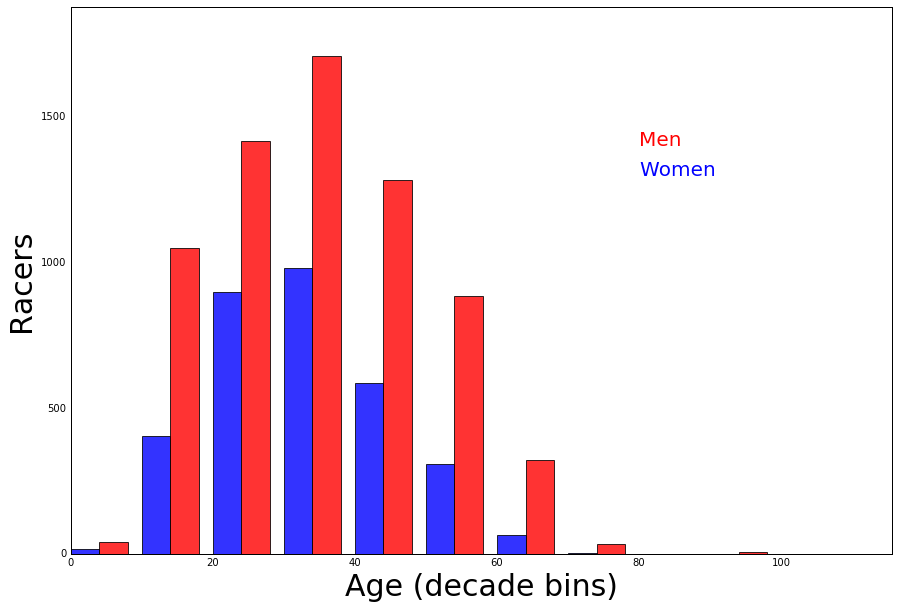

In [12]:
#
# Now, plotting the demographics becomes a simple call to a method
#

racerplots.do_demographics()


# Average Race Times per Wave

In [13]:

print dd.groupby('wave')['time_sec'].mean().head(n=10)


wave
A     2353.465743
AA    2547.557703
AB    2663.235389
B     2776.460581
BA    2824.083799
BB    2884.190383
C     2919.261121
CA    2957.495156
CB    3010.923293
CC    3052.677417
Name: time_sec, dtype: float64


## C3: Specific time question

We can see from the above that the racers in the "C" wave had an average race time of 2919 seconds, or 48 minutes and 39 seconds.

Or, we can use our printing class to look at the average time in every wave ...

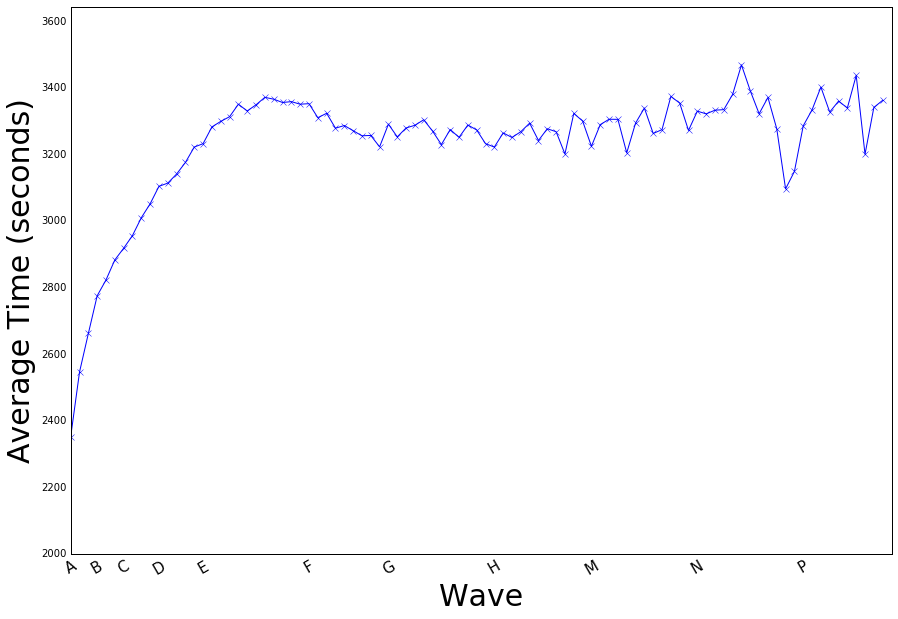

In [14]:
racerplots.do_wave_avgtime()

# Racer Origins

In [15]:
#
# grab wave A and group by city ..
#

agrp = dd.loc[dd['wave'] == "A"]

print "total number of runners in group A=", agrp.shape[0]

# just the city - 
#agrp = agrp.groupby('city').size()
# now, use city-state combo
agrpbycity = agrp.groupby('city-state').size()

print "total number of cities represented by runner in grou A=", agrpbycity.shape[0]

print "top 10 cities of these A group runners"
agrpbycity.sort(ascending=False, inplace=True)
print agrpbycity.head(n=10)


total number of runners in group A= 491
total number of cities represented by runner in grou A= 121
top 10 cities of these A group runners
city-state
boulder-co             85
denver-co              52
fort collins-co        27
colorado springs-co    19
arvada-co              15
broomfield-co          15
louisville-co          14
littleton-co           13
longmont-co            12
aurora-co              12
dtype: int64


## C4: Specific origin question

We see 491 athletes in group A, coming from 121 cities. Boulder, CO, the hometown of the race, was the most frequently represented city, with 85 runners, Followed by Denver, and Fort Collins.

# Fastest times ...

In [16]:
#
# Note, because the sql db ordered the records by finalPlace, we don't need to
# do any sorting here, since the index matches the finalPlace...
#

print "top 10 times:"
print dd.loc[dd['finalPlace'] < 10]

top 10 times:
     id  finalPlace              hometown division      time sex  age  \
0  A615           1            Denver, CO      M28  30:33.94   M   28   
1  A527           2          Lakewood, CO      M24  31:07.32   M   24   
2  A449           3      Fort Collins, CO      M31  31:08.63   M   31   
3  A288           4          Longmont, CO      M18  31:09.15   M   18   
4  A510           5  Colorado Springs, CO      M27  31:40.41   M   27   
5  A475           6           Boulder, CO      M29  32:05.42   M   29   
6  A456           7  Colorado Springs, CO      M25  32:10.88   M   25   
7  A619           8            Denver, CO      M32  32:14.52   M   32   
8  A538           9         Littleton, CO      M18  32:25.30   M   18   

   age_dec              city state           city-state wave  time_sec  
0       20            denver    co            denver-co    A   1833.94  
1       20          lakewood    co          lakewood-co    A   1867.32  
2       30      fort collins    co  

In [17]:
print "top 10 times (females only):"
print min(dd.loc[dd['sex'] ==  "F"]['finalPlace'])
print dd.loc[dd['sex'] ==  "F"].head(n=10)

top 10 times (females only):
105
       id  finalPlace              hometown division      time sex  age  \
104  A089         105           Boulder, CO      F34  35:43.87   F   34   
114  A369         115  Colorado Springs, CO      F31  35:56.72   F   31   
125  A009         126           Boulder, CO      F27  36:10.72   F   27   
129  A117         130           Boulder, CO      F30  36:12.88   F   30   
159  A268         160        Centennial, CO      F17  36:42.51   F   17   
181  A592         182           boulder, CO      F28  37:06.46   F   28   
203  A483         204         Edgewater, CO      F31  37:16.80   F   31   
207  A349         208           Boulder, CO      F28  37:18.15   F   28   
221  A035         222        Broomfield, CO      F28  37:30.77   F   28   
261  A595         262            Denver, CO      F33  38:03.05   F   33   

     age_dec              city state           city-state wave  time_sec  
104       30           boulder    co           boulder-co    A   2

## C5: Specific time question

Males dominated the fastest times, taking the top 104 spots.  The fastest time was 30:33, by a 28 year old male from Denver, CO.

The fastest female time was 35:43.


# Finish Place

In [18]:
#
# OK, where did the old folks finish ...?
#

oldfolks = dd.loc[(dd['sex'] == "M") & (dd['age_dec'] == 40)]

print "total number of well-aged males:", oldfolks.shape[0]
print "the fastest 5:"
print oldfolks.head(n=5)
print "the slowest 5:"
print oldfolks.tail(n=5)


total number of well-aged males: 1281
the fastest 5:
      id  finalPlace            hometown division      time sex  age  age_dec  \
24  A040          25         Boulder, CO      M46  33:36.87   M   46       40   
76  A153          77  Grand Junction, CO      M45  35:19.74   M   45       40   
77  A335          78   COLORADO SPGS, CO      M40  35:20.87   M   40       40   
82  A543          83         Boulder, CO      M49  35:29.07   M   49       40   
88  A092          89      Louisville, CO      M42  35:34.36   M   42       40   

              city state         city-state wave  time_sec  
24         boulder    co         boulder-co    A   2016.87  
76  grand junction    co  grand junction-co    A   2119.74  
77   colorado spgs    co   colorado spgs-co    A   2120.87  
82         boulder    co         boulder-co    A   2129.07  
88      louisville    co      louisville-co    A   2134.36  
the slowest 5:
         id  finalPlace      hometown division      time sex  age  age_dec  \
9

## C6: specific final place question

There's a huge spread in the final placing of wise old men, i.e., those in their 40's.  Actually, it's quite amazing ... a 46 year old was the 25th fastest person in the race, and a 43 year old was the 11th slowest.  So, basically this group was spread all the way across the finish.

And just cause it's fun, we can explicitly look at the average finish place for each age group here: we see explicitly that men are faster than women, and you people (at least older than 10) are faster than old people.  Which I guess are the sad facts of life ....

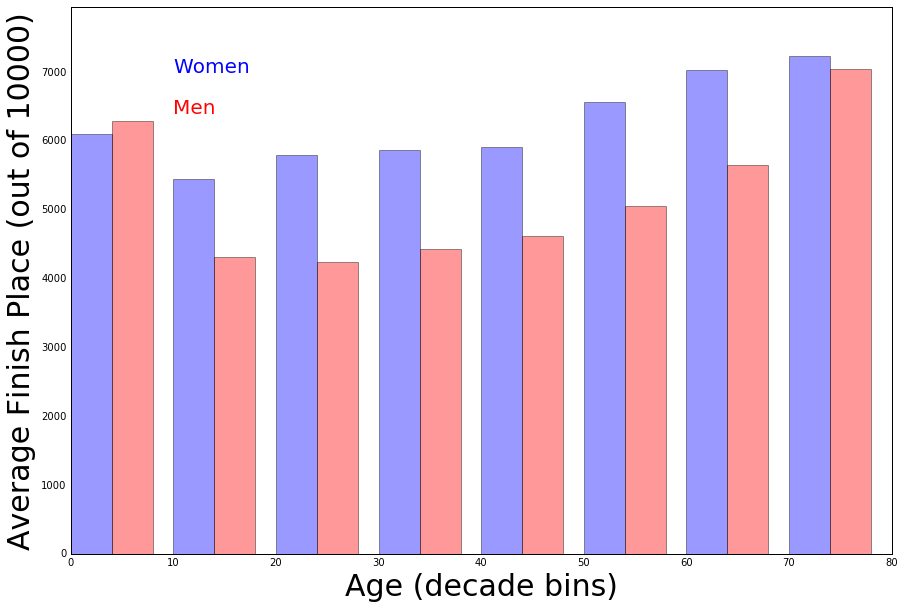

In [19]:
racerplots.do_age_avgfinish()

# Post-mortem

OK, it's been a little bit of a random project, since I started the reading in and data processing last weekend, but then had some difficulty finding many blocks of time throughout the week to work on this.  In any event, it was a fun project to work on.

## D1: Decisions

My decisions were more practical than anything else.  I knew I could employ a python framework to get these questions answered.  Plus, in terms of a "tool" it's not bad for a certain class of users, i.e., those people who are technically advanced enough to do command-line data processing.  And this is a decent platform for collaborative work since the class structure is easily extended and built upon, which I think is useful.

##D2: Evaluation
Are these visualizations effective?  It's hard for me to say "no" since I just built them... but in general I think they convey the messages that we're trying to get across.  Maybe it's not that interactive, so that's a definite drawback, and maybe you need to be semi-saavy with technology which is also a drawback, but I know I could effectively use this tool to answer lots of additional questions as they popped up.  And I think/hope that other could too.

##D3: Importance
The important things to me are:
 
1. Is the information correct?  We've installed a set of checks and balances (still a little bit manual in implementation) which have tried to ensure this is the case.

2. Did we effectively convey the information?  I think we did.  As I just said, it might not be the cleanest and most user-friendly tool, but the information is definitely there.  And some of the figures are actually quite nice a visually displaying the cold, hard facts of the ability of men and women of all ages to race.

2. Can this be easily extended to answer additional questions, i.e., is this a useful "tool"?  Again, I think so.  Of course, the answer depends on the knowledge set of the audience/user so maybe that's a significant caveat.